# Libray

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import datetime
import random
import glob

# Load Data
Use the CIFAR data set reader from the first homework and read the CIFAR-10 files again. 

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [3]:
def load_cfar10_batch(path='../cifar-10-batches-py/data_batch_*'):
    files = glob.glob(path)
    features = np.concatenate([unpickle(x)['data'] for x in files])
    labels = np.concatenate([unpickle(x)['labels'] for x in files])
        
    return features, labels

In [4]:
features, labels = load_cfar10_batch()

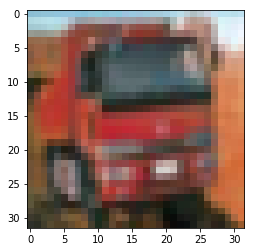

In [5]:
img = features[30]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)

plt.imshow(img)

# Random Noise
Apply random noise to the image

In [6]:
def random_noise(image):
    return np.asarray(np.clip(image + np.random.normal(0, 10, image.shape), 0, 255), dtype=np.uint8)

features_random = random_noise(features)

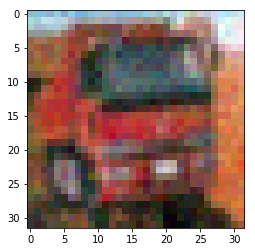

In [7]:
img = features_random[30]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)

plt.imshow(img)

# Normalization
Convert the image to float and scale to [0.0, 1.0] by dividing the pixel values by the highest pixel value.

In [8]:
def normalize_images(images):
#     images = images / 255
    images = np.divide(images, 255)
    return images

features_random_z = normalize_images(features_random)

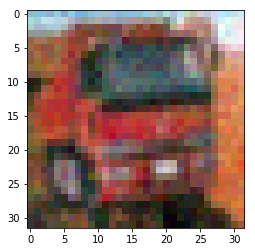

In [9]:
img = features_random_z[30]
img = img.reshape(3, 32, 32).transpose(1, 2, 0)

plt.imshow(img)

In [10]:
features_random.max()

255

In [11]:
features_random_z.max()

1.0

# Onehot
Convert all labels to onehot encoding.

In [12]:
def toOneHot(data):
    v = data
    oneHot = np.zeros([50000,10])
    oneHot[np.arange(50000), v] = 1
    data = oneHot
    return data

In [13]:
labels_onehot = toOneHot(labels)

In [14]:
labels[30]

9

In [15]:
labels_onehot[30]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

# Tensor Flow

In [16]:
class TF_Cifar10:
    def __init__(self, input_data, input_label, learning_rates=0.001):

        nepochs = 100
        batch_size = 128
        nhidden1 = 512
        nhidden2 = 256 
        nhidden3 = 128 
        ninput = input_data[0].flatten().shape[0]
        noutput = 10

        X = tf.placeholder(tf.float32, [batch_size, ninput])
        Y = tf.placeholder(tf.float32, [batch_size, noutput])

        weights = {'h1': tf.Variable(tf.random_normal([ninput, nhidden1])),
                   'h2': tf.Variable(tf.random_normal([nhidden1, nhidden2])),
                   'h3': tf.Variable(tf.random_normal([nhidden2, nhidden3])),
                   'out': tf.Variable(tf.random_normal([nhidden3, noutput]))}

        biases = {'b1': tf.Variable(tf.random_normal([nhidden1])),
                  'b2': tf.Variable(tf.random_normal([nhidden2])),
                  'b3': tf.Variable(tf.random_normal([nhidden3])),
                  'out': tf.Variable(tf.random_normal([noutput]))}

        model = self.multiperceptron(X, weights, biases)

        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rates)
        train_min = optimizer.minimize(loss)

        correct_prediction = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)

        tf.summary.histogram('weight_1',weights['h1'])
        tf.summary.histogram('weight_2',weights['h2'])
        tf.summary.histogram('weight_3',weights['h3'])
        tf.summary.scalar('loss', loss)

        merged_summary_op = tf.summary.merge_all()
        filename = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S_learning_rate_'+str(learning_rates))
        writer = tf.summary.FileWriter(filename, tf.get_default_graph())
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)

            for epoch in range(nepochs):
                for batch_x, batch_y in self.getbatch(input_data, input_label, batch_size):
                    sess.run(train_min, feed_dict={X:batch_x, Y:batch_y})
                losscalc, accuracycalc, merged_summary = \
                              sess.run([loss, accuracy, merged_summary_op], feed_dict={X:batch_x, Y:batch_y})
                writer.add_summary(merged_summary, epoch)

            print('Epoch: %d, Loss: %0.3f, Accuracy: %0.3f'%(epoch, losscalc, accuracycalc))

        sess.close()
        writer.close()

    def multiperceptron(self, x, weights, biases):
        l1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['h1']), biases['b1']))
        l2 = tf.nn.sigmoid(tf.add(tf.matmul(l1, weights['h2']), biases['b2']))
        l3 = tf.nn.sigmoid(tf.add(tf.matmul(l2, weights['h3']), biases['b3']))
        outl = tf.nn.sigmoid(tf.add(tf.matmul(l3, weights['out']), biases['out']))
        return outl

    def getbatch(self, alldata, alllabels, batch_size = 16):
        nlabels = len(alllabels)
        number_of_batches = nlabels//batch_size
        for batch_number in range(number_of_batches):
            rand_index = [random.randrange(0, nlabels) for i in range(batch_size)]
            batch_x = alldata[rand_index]
            batch_y = np.array([alllabels[idx] for idx in rand_index])
            yield (batch_x, batch_y)

In [17]:
tf_cifar10_01 = TF_Cifar10(features_random_z, labels_onehot, learning_rates=0.001)

Instructions for updating:
Colocations handled automatically by placer.
Epoch: 99, Loss: 1.848, Accuracy: 0.531


# Result
Trained three type of networks with learning rates of (0.1, 0.01 and 0.001). Each network train in 100 epoch.

In this snapshot taken from tensorboard, there are different learnning rates. A orange line is 0.1, a blue line is 0.01 and a red line is 0.01.

The networks of which learnning rate of (0.1 and 0.01) showed bad results. The loss value was 2.30, and the accuracy value which was only 0.1 did not change.

On the other hand, the network of which learnning rate of 0.001 was better than them. The loss value declined to 1.9, and the accuracy value improved to 0.45.

<img src="./pictures/Screenshot from 2019-03-11 14-02-16.png" width="1920px">

<img src="./pictures/Screenshot from 2019-03-11 14-02-44.png" width="1920px">

<img src="./pictures/Screenshot from 2019-03-11 14-04-58.png" width="1920px">